# **Setup and package installations**

In [1]:

!pip install numpy==1.26.4
!pip install pandas
!pip install scikit-learn
!pip install transformers==4.30.2 datasets==2.12.0
!pip install xgboost==2.0.3

# **Imports**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics        import f1_score, classification_report, confusion_matrix

import torch
from torch.optim          import AdamW

from transformers import (
    DistilBertTokenizerFast,
    DistilBertModel,
    DistilBertPreTrainedModel
)
import torch.nn as nn


# **Loading Data and starting preprocessing**

In [3]:
import os, re
import pandas as pd
import numpy as np

DATA_PATH = "/content/train.csv"   #loding the file here

def load_table(path):
    low = path.lower()
    if low.endswith((".xlsx", ".xls")):
        return pd.read_excel(path, sheet_name=0)
    if low.endswith(".csv"):
        return pd.read_csv(path)
    try:
        return pd.read_csv(path)
    except:
        return pd.read_excel(path, sheet_name=0)

# LoadIng
df = load_table(DATA_PATH)


rename_map = {
    "Instruction":"instruction",
    "Input":"input",
    "Output":"output",
    "Data Source":"data_source",
    "data source":"data_source",
    "Category":"category",
    "Label":"category"
}
df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns}, inplace=True)


for col in ["instruction","input","output"]:
    if col not in df.columns:
        df[col] = ""

# basic cleaning the dataset
df.dropna(subset=["instruction"], inplace=True)
df["instruction"] = df["instruction"].astype(str)
df["input"]       = df["input"].fillna("").astype(str)




In [4]:
print("Columns:", list(df.columns))

Columns: ['input', 'output', 'instruction', 'data_source']


In [5]:
print(df.head())

  input                                             output  \
0        To find the probability of the spinner landing...   
1        I need to choose 6 people out of 14, and the o...   
2        First we count the number of all 4-letter word...   
3        She can do this if and only if at least one of...   
4        Think of the problem as a sequence of H's and ...   

                                         instruction    data_source  
0  A board game spinner is divided into three par...  MATH/PRM-800K  
1  My school's math club has 6 boys and 8 girls. ...  MATH/PRM-800K  
2  How many 4-letter words with at least one cons...  MATH/PRM-800K  
3  Melinda will roll two standard six-sided dice ...  MATH/PRM-800K  
4  Let $p$ be the probability that, in the proces...  MATH/PRM-800K  


In [6]:
print(df.tail())

      input                                             output  \
24921        There are several formulas that generate all p...   
24922        Sure, here are some of the best universities:\...   
24923        [Enter stage left]\n\nFirst Citizen: Good morr...   
24924        That's a very thoughtful idea! Here are some s...   
24925        Certainly! Here's an implementation of the Tim...   

                                             instruction data_source  
24921  Can we find a formula to generate all prime nu...     guanaco  
24922  What are some of the best university's for stu...     guanaco  
24923  Write me a SPL (Shakespeare Programming Langua...     guanaco  
24924  Hi. I want to make an embossed picture for my ...     guanaco  
24925  Please implement the Timsort algorithm on Lean...     guanaco  


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24926 entries, 0 to 24925
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input        24926 non-null  object
 1   output       24926 non-null  object
 2   instruction  24926 non-null  object
 3   data_source  24926 non-null  object
dtypes: object(4)
memory usage: 779.1+ KB
None


# **Data categorizer**

In [8]:

import re

def _normalize_and_tokens(s: str):
    t = (s or "").lower()
# normalizing various symbols
    t = (t.replace("χ²", "chi2")
           .replace("chi-square", "chisquare")
           .replace("χ2", "chi2")
           .replace("×", "x")
           .replace("≡", " congruent ")
           .replace("∣", " divides ")
           .replace("std. dev", "standard deviation")
           .replace("std dev", "standard deviation")
           .replace("std.", "std")
           .replace("c.i.", "ci")
           .replace("r^2", "r2")
           .replace("r-squared", "r2"))
    tokens = set(re.findall(r"[a-z0-9]+", t))
    return t, tokens

def _has_grid_size(t: str):

    return bool(re.search(r"\b[2-9]x[2-9]\b", t))

def _has_prob_notation(raw: str):
    return (
        bool(re.search(r"\bP\s*\(", raw)) or
        bool(re.search(r"\bE\s*[\(\[]", raw)) or
        "var(" in raw or "var[" in raw or
        "σ" in raw or "μ" in raw or "lambda" in raw or "λ" in raw or
        "∩" in raw or "∪" in raw or
        bool(re.search(r"~\s*(n|normal|gaussian|poisson|binomial|exp|exponential|uniform)", raw)) or
        "cdf" in raw or "pdf" in raw or "pmf" in raw
    )

def _has_stats_output_notation(t: str):
    return any(k in t for k in ["t=","z=","chi2=","r2=","df=","sse","sst","msb","msw","mse","se="])

def _has_comb_notation(t: str):
    return bool(re.search(r"\b\d+\s*c\s*\d+\b", t)) or \
           bool(re.search(r"\b\d+\s*p\s*\d+\b", t)) or \
           bool(re.search(r"\bc\s*\(\s*\d+\s*,\s*\d+\s*\)", t))

# dividing keywords for probabilty and statistics
STATS_WORDS = {
    "mean","median","mode","variance","sd","std","standard","deviation",
    "sample","sampling","population","pvalue","hypothesis","test","statistic",
    "ztest","ttest","chisquare","chi2","anova","ftest","zscore","tstatistic","tstat",
    "regression","logistic","correlation","pearson","spearman","coefficient","slope","intercept",
    "se","standarderror","confidence","interval","alpha","df","degrees","freedom",
    "r2","mse","sse","sst","msb","msw","residual","residuals","likelihood","bayes","posterior","prior","estimator","estimate"
}
STATS_PHRASES = {
    "confidence interval","p value","confidence level","goodness of fit","degrees of freedom","type i error","type ii error","power analysis"
}

PROB_OBJECTS = {
    "die","dice","coin","spinner","urn","marble","marbles","ball","balls",
    "deck","card","cards","heart","hearts","spade","spades","club","clubs","diamond","diamonds",
    "draw","draws","box"
}
PROB_TERMS = {"probability","probabilities","probabilistic","odds","chance","expected","expectation","independent","dependent","mutually","exclusive","random","randomly","at","random"}
DISTRIB_WORDS = {"binomial","geometric","hypergeometric","poisson","exponential","uniform","normal","gaussian","bernoulli","gamma","beta"}
PROB_PHRASES = {"with replacement","without replacement","normal distribution","uniform distribution","chosen at random","at random"}

# dividing keywords for Combinatorics
COMB_WORDS = {
    "permutation","permutations","combination","combinations",
    "arrangement","arrangements","ordering","orderings","order","orders",
    "positions","seat","seats","seating","circular","round","table","adjacent","nonadjacent",
    "factorial","choose","derangement","derangements","subset","subsets","committee","partition","partitions",
    "pigeonhole","inclusion","exclusion","catalan","ncr","npr","binom","assign","assignment","distribute","distribution",
    "gap","gaps","between","place","placing","select","selection","binary","bit","bitstring","bitstrings",
    "string","strings","letters","anagram","anagrams","multiset","stirling","bell","composition","compositions"
}
COMB_PHRASES = {
    "how many ways","number of ways","how many","number of","at least","at most","no two","not adjacent","no two adjacent"
}

# dividing keywords for  Logic Puzzles
LOGIC_PHRASES = {
    "latin square","magic square","lights out","bridge crossing","river crossing","knight s tour",
    "hourglass puzzle","locker puzzle","nonattacking","non attacking","calendar puzzle","clock puzzle"
}
LOGIC_WORDS = {
    "latin","magic","square","sudoku","grid","board","row","column","cell","cells",
    "lights","toggle","tiling","domino","dominoes","tromino","trominoes","pentomino","pentominoes",
    "rook","bishop","knight","queen","queens","rooks","bishops","chess","tour","path","paths",
    "tournament","euler","hamilton","invariant","graph","graphs","vertex","vertices","edge","edges","degree","degrees",
    "digits","digit","neighbors","neighbours","difference","cycle","cycles","matching","cover","covering","nonattacking"
}
# extra customizable cues
LOGIC_PHRASES = LOGIC_PHRASES | {
    "three switches", "three light switches", "enter the room once",
    "which switch controls", "only enter once"
}
LOGIC_WORDS = LOGIC_WORDS | {
    "switch","switches","bulb","light","room","door","riddle","puzzle","teaser","brain"
}

def _is_switch_bulb_puzzle(toks):
    return (("switch" in toks or "switches" in toks) and
            ("bulb" in toks or "light" in toks) and
            ("room" in toks or "enter" in toks or "door" in toks))


# dividing keywords for Math Word Problems
WORDPROB_WORDS = {
    # algebra,geometry,rates
    "solve","equation","algebra","linear","quadratic","geometry","triangle","circle","area",
    "perimeter","volume","angle","rate","speed","distance","time","work","mixture",
    "concentration","percent","percentage","age","interest","profit","cost","price","ratio","proportion","similar","pythagorean",
    # sequences,series
    "sequence","series","ap","gp","arithmetic","geometric","harmonic","recurrence","fibonacci","term","nth","sum","partial","difference",
    # number-theory
    "prime","composite","divisible","divisibility","remainder","mod","modulo","congruent","congruence",
    "gcd","lcm","factor","factors","divisor","divisors","multiple","multiples","power","perfect","square","cube",
    "palindrome","armstrong","digit","digits","units","tens","hundreds","thousands","digit sum","sum of digits","floor","ceiling","ceil","floor"
}


In [9]:
# calling all the functions back based on the keywords of the particular question.

def categorize_logical_problem(row):
    raw = f"{row.get('instruction','')} {row.get('input','')}"
    t, toks = _normalize_and_tokens(raw)

    if any(ph in t for ph in STATS_PHRASES) or (STATS_WORDS & toks) or _has_stats_output_notation(t):
        return "Probability & Statistics"

    if (PROB_OBJECTS & toks) and (
        (PROB_TERMS & toks) or (DISTRIB_WORDS & toks) or any(ph in t for ph in PROB_PHRASES) or _has_prob_notation(raw)
    ):
        return "Probability & Statistics"

    if _has_grid_size(t) or any(ph in t for ph in LOGIC_PHRASES) or (LOGIC_WORDS & toks) or _is_switch_bulb_puzzle(toks):
        return "Logic Puzzles"

    if any(ph in t for ph in COMB_PHRASES) or (COMB_WORDS & toks) or _has_comb_notation(t):
        return "Combinatorics"

    if WORDPROB_WORDS & toks:
        return "Math Word Problems"

    return "General Reasoning"

df['category'] = df.apply(categorize_logical_problem, axis=1)
df['has_input'] = (df['input'].str.strip() != "").astype(int)
print(df['category'].value_counts())

category
Combinatorics               6401
General Reasoning           5943
Probability & Statistics    5495
Logic Puzzles               3563
Math Word Problems          3524
Name: count, dtype: int64


# **Exploratory Data Analysis**

1. joins texts and  simple tokenizer

In [10]:
import re, math, collections, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")


df['_text'] = df.apply(lambda r: r['instruction'] if not str(r['input']).strip()
                       else f"{r['instruction']} [SEP] {r['input']}", axis=1)

def simple_tokens(s: str):
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", " ", s)
    return [t for t in s.split() if t]

# Length features
df['_len_char'] = df['_text'].str.len()
df['_len_tok']  = df['_text'].apply(lambda s: len(simple_tokens(s)))

print("Shape:", df.shape)
print("\nCategory counts:\n", df['category'].value_counts())


Shape: (24926, 9)

Category counts:
 category
Combinatorics               6401
General Reasoning           5943
Probability & Statistics    5495
Logic Puzzles               3563
Math Word Problems          3524
Name: count, dtype: int64


2. missing values

Nulls per column:
 input          0
output         0
instruction    0
data_source    0
category       0
has_input      0
_text          0
_len_char      0
_len_tok       0
dtype: int64


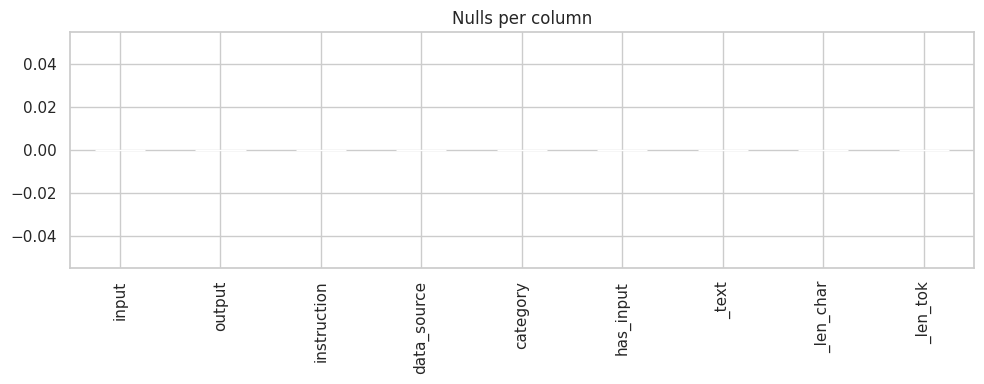

In [11]:
nulls = df.isna().sum().sort_values(ascending=False)
print("Nulls per column:\n", nulls)

# bar plotting for missing values
plt.figure(figsize=(10,4))
nulls.plot(kind='bar')
plt.title("Nulls per column"); plt.tight_layout(); plt.show()


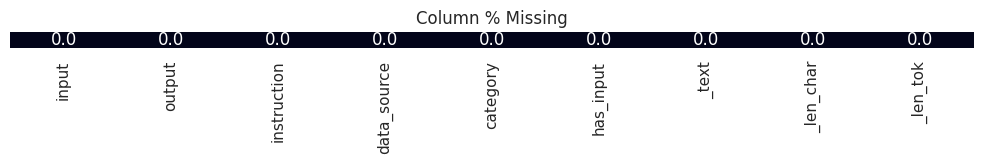

In [12]:
# missing values heat map comunn level
null_pct = (df.isna().mean()*100).to_frame(name="% missing").T
plt.figure(figsize=(10,1.8))
sns.heatmap(null_pct, annot=True, fmt=".1f", cbar=False)
plt.title("Column % Missing");
plt.yticks([]);
plt.tight_layout();
plt.show()


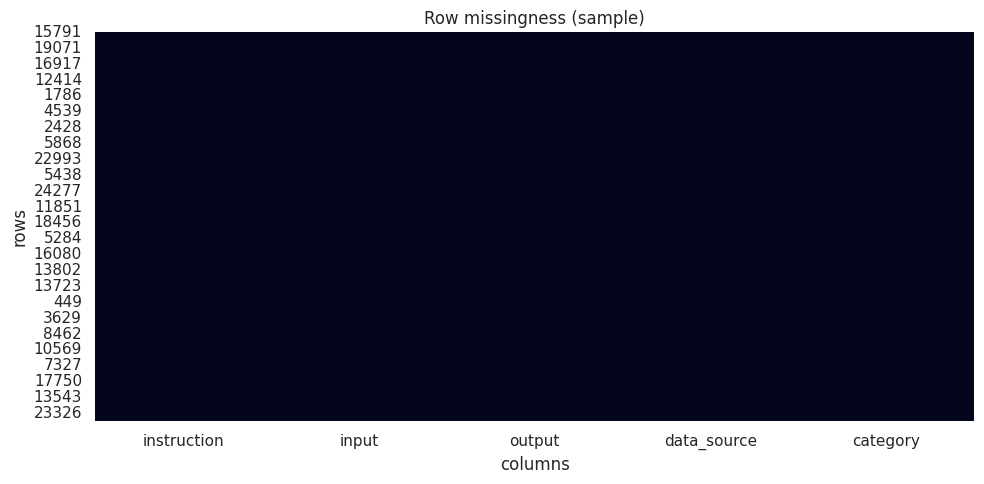

In [13]:
# checking missing values row level
cols_to_check = ['instruction','input','output','data_source','category'] if 'data_source' in df.columns \
                else ['instruction','input','output','category']
sample_missing = df[cols_to_check].sample(min(1200, len(df)), random_state=7)
plt.figure(figsize=(10,5))
sns.heatmap(sample_missing.isna(), cbar=False)
plt.title("Row missingness (sample)");
plt.xlabel("columns");
plt.ylabel("rows");
plt.tight_layout();
plt.show()

**3. Checking category distribution of data**

,count,percent
category,,
Combinatorics,6401,25.68
General Reasoning,5943,23.84
Probability & Statistics,5495,22.05
Logic Puzzles,3563,14.29
Math Word Problems,3524,14.14


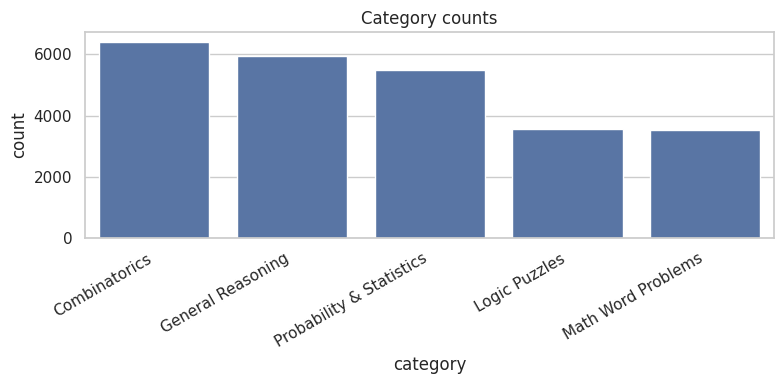

In [14]:

counts = df['category'].value_counts()
pct = 100 * counts / counts.sum()
display(pd.DataFrame({'count': counts, 'percent': pct.round(2)}))

plt.figure(figsize=(8,4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Category counts"); plt.ylabel("count"); plt.xlabel("category")
plt.xticks(rotation=30, ha='right');
plt.tight_layout();
plt.show()


**4. checking length distribution using histograms**

Char length quantiles:
 0.50     242.00
0.90    1283.00
0.95    1785.75
0.99    3595.75
Name: _len_char, dtype: float64

Token length quantiles:
 0.50     45.0
0.90    217.0
0.95    306.0
0.99    558.0
Name: _len_tok, dtype: float64


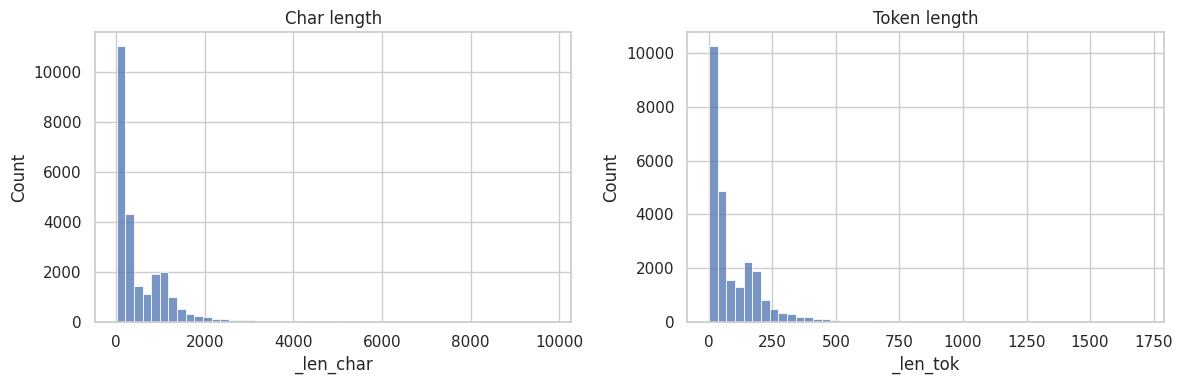


Median token length by category:
 category
Probability & Statistics    149.0
Combinatorics               123.0
Logic Puzzles                52.0
Math Word Problems           30.0
General Reasoning            22.0
Name: _len_tok, dtype: float64


In [15]:

df['_len_char'] = df['_text'].str.len()
df['_len_tok']  = df['_text'].apply(lambda s: len(simple_tokens(s)))

print("Char length quantiles:\n", df['_len_char'].quantile([.5,.9,.95,.99]))
print("\nToken length quantiles:\n", df['_len_tok'].quantile([.5,.9,.95,.99]))

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df['_len_char'], bins=50, ax=ax[0])
ax[0].set_title("Char length")
sns.histplot(df['_len_tok'], bins=50, ax=ax[1])
ax[1].set_title("Token length")
plt.tight_layout();
plt.show()

med_len = df.groupby('category')['_len_tok'].median().sort_values(ascending=False)
print("\nMedian token length by category:\n", med_len)


**5. Checking for duplicates**

In [16]:
dup_exact_mask = df['_text'].duplicated(keep=False)
dup_exact_count = int(dup_exact_mask.sum())
print("Exact duplicate rows:", dup_exact_count)

def fingerprint(s: str):
    s = s.lower()
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[^a-z0-9 ]+', '', s)
    return s.strip()

df['_fp'] = df['_text'].map(fingerprint)
dup_near_mask = df['_fp'].duplicated(keep=False)
dup_near_count = int(dup_near_mask.sum())
print("Near-exact duplicate rows (fingerprint):", dup_near_count)

if dup_exact_count:
    print("\nTop exact duplicate clusters:")
    (df[dup_exact_mask]
     .groupby('_text')
     .size()
     .sort_values(ascending=False)
     .head(3)
     .to_frame("dup_count")
     .pipe(display))


Exact duplicate rows: 0
Near-exact duplicate rows (fingerprint): 33


**6. Box plots**

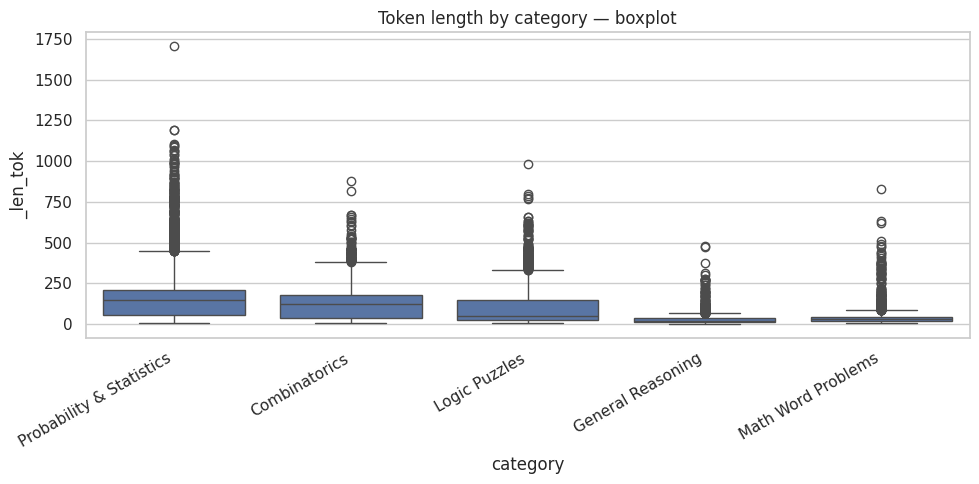

In [17]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='category', y='_len_tok')
plt.title("Token length by category — boxplot")
plt.xticks(rotation=30, ha='right');
plt.tight_layout();
plt.show()


**7. scatter plot**

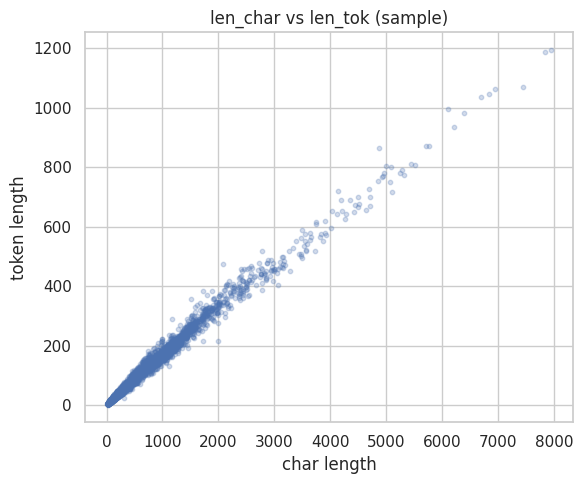

In [18]:
samp = df.sample(min(6000, len(df)), random_state=11)[['_len_char','_len_tok','category']]
plt.figure(figsize=(6,5))
plt.scatter(samp['_len_char'], samp['_len_tok'], alpha=0.25, s=10)
plt.xlabel("char length"); plt.ylabel("token length"); plt.title("len_char vs len_tok (sample)")
plt.tight_layout();
plt.show()


**8.Correlation heatmap**

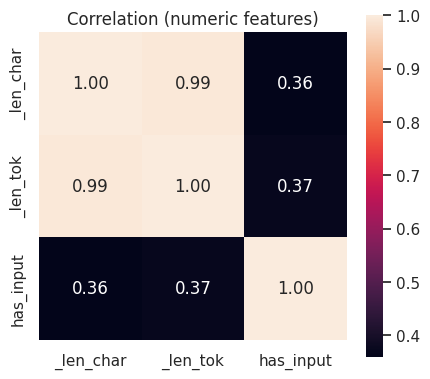

In [19]:
num_cols = ['_len_char','_len_tok','has_input']
if 'label_encoded' in df.columns:
    num_cols.append('label_encoded')
corr = df[num_cols].corr()
plt.figure(figsize=(4.5,4))
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.title("Correlation (numeric features)"); plt.tight_layout();
plt.show()


# **Tokenizer length and  model limit**

In [20]:
if 'tokenizer' in globals():
    sample_texts = df['_text'].sample(min(3000, len(df)), random_state=2).tolist()
    enc = tokenizer(sample_texts, truncation=False, padding=False)
    lens = [len(ids) for ids in enc['input_ids']]
    q = np.quantile(lens, [0.5,0.9,0.95,0.99,1.0])
    print("WordPiece token length quantiles:", q)
    print("Percent > 256 tokens:", 100*float(np.mean(np.array(lens) > 256)))
else:
    print("Define `tokenizer` first (e.g., DistilBERT) to run this cell.")


Define `tokenizer` first (e.g., DistilBERT) to run this cell.


# **label encoder and data splitting**

In [21]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['category'])
CLASSES = list(label_encoder.classes_)

X = df[['instruction','input']]
y = df['label_encoded'].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Classes:", CLASSES)
print("Train:", X_train_raw.shape, " Test:", X_test_raw.shape)


Classes: ['Combinatorics', 'General Reasoning', 'Logic Puzzles', 'Math Word Problems', 'Probability & Statistics']
Train: (19940, 2)  Test: (4986, 2)


# **TF-IDF,Logistic Regression**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def join_text(a, b):
    return [aa if not str(bb).strip() else f"{aa} [SEP] {bb}" for aa,bb in zip(a.tolist(), b.tolist())]

Xtr_txt = join_text(X_train_raw['instruction'], X_train_raw['input'])
Xte_txt = join_text(X_test_raw['instruction'],  X_test_raw['input'])

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)
Xtr = tfidf.fit_transform(Xtr_txt)
Xte = tfidf.transform(Xte_txt)

lr = LogisticRegression(max_iter=2000, n_jobs=-1)
lr.fit(Xtr, y_train)
pred = lr.predict(Xte)
print("=== TF-IDF + LR baseline ===")
print(classification_report(y_test, pred, target_names=CLASSES, digits=3))


=== TF-IDF + LR baseline ===
                          precision    recall  f1-score   support

           Combinatorics      0.716     0.828     0.768      1280
       General Reasoning      0.841     0.950     0.892      1189
           Logic Puzzles      0.903     0.651     0.756       713
      Math Word Problems      0.835     0.759     0.795       705
Probability & Statistics      0.735     0.673     0.703      1099

                accuracy                          0.788      4986
               macro avg      0.806     0.772     0.783      4986
            weighted avg      0.793     0.788     0.785      4986



# **Rule features (multi-hot)**

In [23]:
import numpy as np, re

# these are the helpers

def _is_switch_bulb_puzzle_tokens(toks):
    return (("switch" in toks or "switches" in toks) and
            ("bulb" in toks or "light" in toks) and
            ("room" in toks or "enter" in toks or "door" in toks))

def _norm_tokens(s: str):
    t = (s or "").lower()
    t = (t.replace("χ²", "chi2").replace("chi-square","chisquare")
           .replace("χ2","chi2").replace("×","x").replace("r^2","r2").replace("r-squared","r2"))
    toks = set(re.findall(r"[a-z0-9]+", t))
    return t, toks

def _has_grid_size(t: str):
    return bool(re.search(r"\b[2-9]x[2-9]\b", t))

def _has_comb_notation(t: str):
    return bool(re.search(r"\b\d+\s*c\s*\d+\b", t)) or bool(re.search(r"\b\d+\s*p\s*\d+\b", t)) \
           or bool(re.search(r"\bc\s*\(\s*\d+\s*,\s*\d+\s*\)", t))

def _prob_notation(raw: str):
    return (bool(re.search(r"\bP\s*\(", raw)) or bool(re.search(r"\bE\s*[\(\[]", raw)) or
            "var(" in raw or "σ" in raw or "μ" in raw or "λ" in raw or "∩" in raw or "∪" in raw)

def _stats_out_notation(t: str):
    return any(k in t for k in ["t=","z=","chi2=","r2=","df=","sse","sst","msb","msw","mse","se="])

#most of the words already defined in the catogory cell

def rules_multi_hot(full_text: str, classes):
    t, toks = _norm_tokens(full_text)
    fired = {c:0 for c in classes}
# so here we are making rules using the keywords we identified in catogory cell based on those model will find the or label the type of question

    # Probability & Statistics section
    ps = (any(ph in t for ph in STATS_PHRASES) or (STATS_WORDS & toks) or _stats_out_notation(t)) \
         or ((PROB_OBJECTS & toks) and ((PROB_TERMS & toks) or (DISTRIB_WORDS & toks) or
             any(ph in t for ph in PROB_PHRASES) or _prob_notation(full_text)))
    if "Probability & Statistics" in fired and ps:
        fired["Probability & Statistics"] = 1

    # Logic Puzzles section
    lg = _has_grid_size(t) or any(ph in t for ph in LOGIC_PHRASES) or (LOGIC_WORDS & toks)
    if "Logic Puzzles" in fired and lg:
        fired["Logic Puzzles"] = 1

    # Combinatorics section
    cb = any(ph in t for ph in COMB_PHRASES) or (COMB_WORDS & toks) or _has_comb_notation(t)
    if "Combinatorics" in fired and cb:
        fired["Combinatorics"] = 1

    # Math Word Problems section
    mw = (WORDPROB_WORDS & toks)
    if "Math Word Problems" in fired and mw:
        fired["Math Word Problems"] = 1

    # general reasoning section
    if sum(fired.values()) == 0 and "General Reasoning" in fired:
        fired["General Reasoning"] = 1

    return np.array([fired[c] for c in classes], dtype=np.float32)

rule_features_train = np.stack([
    rules_multi_hot(f"{r.instruction} {r.input}", CLASSES) for r in X_train_raw.itertuples(index=False)
])
rule_features_test = np.stack([
    rules_multi_hot(f"{r.instruction} {r.input}", CLASSES) for r in X_test_raw.itertuples(index=False)
])

print("Rule feature shapes:", rule_features_train.shape, rule_features_test.shape)


Rule feature shapes: (19940, 5) (4986, 5)


# **LogReg rule feature**

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr_rules = LogisticRegression(max_iter=2000, n_jobs=-1)
lr_rules.fit(rule_features_train, y_train)
pred_rules = lr_rules.predict(rule_features_test)
print("=== Rules-only (multi-hot) + LR baseline ===")
print(classification_report(y_test, pred_rules, target_names=CLASSES, digits=3))


=== Rules-only (multi-hot) + LR baseline ===
                          precision    recall  f1-score   support

           Combinatorics      0.999     1.000     1.000      1280
       General Reasoning      1.000     1.000     1.000      1189
           Logic Puzzles      1.000     1.000     1.000       713
      Math Word Problems      1.000     1.000     1.000       705
Probability & Statistics      1.000     0.999     1.000      1099

                accuracy                          1.000      4986
               macro avg      1.000     1.000     1.000      4986
            weighted avg      1.000     1.000     1.000      4986



# **Tokenizer and texts**

In [36]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def join_text(a_series, b_series):
    out = []
    for a,b in zip(a_series.tolist(), b_series.tolist()):
        out.append(a if not str(b).strip() else f"{a} [SEP] {b}")
    return out

train_texts = join_text(X_train_raw['instruction'], X_train_raw['input'])
test_texts  = join_text(X_test_raw['instruction'],  X_test_raw['input'])

max_len = 288
train_enc = tokenizer(train_texts, truncation=True, padding=True, max_length=max_len, return_tensors='pt')
test_enc  = tokenizer(test_texts,  truncation=True, padding=True, max_length=max_len, return_tensors='pt')

print({k: v.shape for k,v in train_enc.items()})


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'input_ids': torch.Size([19940, 288]), 'attention_mask': torch.Size([19940, 288])}


# **Training/val  and split inside the training set**

In [37]:

import numpy as np
from sklearn.model_selection import train_test_split

N = len(y_train)
all_ids = np.arange(N)
train_ids, val_ids = train_test_split(
    all_ids, test_size=0.10, random_state=42, stratify=y_train
)

train_enc_sub = {
    'input_ids':       train_enc['input_ids'][train_ids],
    'attention_mask':  train_enc['attention_mask'][train_ids]
}
val_enc = {
    'input_ids':       train_enc['input_ids'][val_ids],
    'attention_mask':  train_enc['attention_mask'][val_ids]
}

y_train_sub = y_train[train_ids]
y_val       = y_train[val_ids]

rf_train_sub = rule_features_train[train_ids]
rf_val       = rule_features_train[val_ids]

print("Train subset:", train_enc_sub['input_ids'].shape, " Val:", val_enc['input_ids'].shape)


Train subset: torch.Size([17946, 288])  Val: torch.Size([1994, 288])


# **Oversampling by using the weights**

In [38]:
import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import numpy as np

# Training set
train_dataset = TensorDataset(
    train_enc_sub['input_ids'],
    train_enc_sub['attention_mask'],
    torch.tensor(rf_train_sub, dtype=torch.float32),
    torch.tensor(y_train_sub, dtype=torch.long)
)

# Validation set
val_dataset = TensorDataset(
    val_enc['input_ids'],
    val_enc['attention_mask'],
    torch.tensor(rf_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.long)
)

# Test set
test_dataset = TensorDataset(
    test_enc['input_ids'],
    test_enc['attention_mask'],
    torch.tensor(rule_features_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)

# Weighted sampler on the *training  subset*
class_counts = np.bincount(y_train_sub, minlength=len(CLASSES))
class_weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = class_weights[y_train_sub]
sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.float32),
    num_samples=len(sample_weights),
    replacement=True
)

# Loaders
BATCH_TRAIN = 24
BATCH_EVAL  = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, sampler=sampler)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_EVAL, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_EVAL, shuffle=False)

print("Class counts (train subset):", dict(zip(CLASSES, class_counts)))
print("WeightedRandomSampler ready. Val/Test loaders ready.")


Class counts (train subset): {'Combinatorics': 4609, 'General Reasoning': 4279, 'Logic Puzzles': 2565, 'Math Word Problems': 2537, 'Probability & Statistics': 3956}
WeightedRandomSampler ready. Val/Test loaders ready.


# **Pie charts: before vs after oversampling**

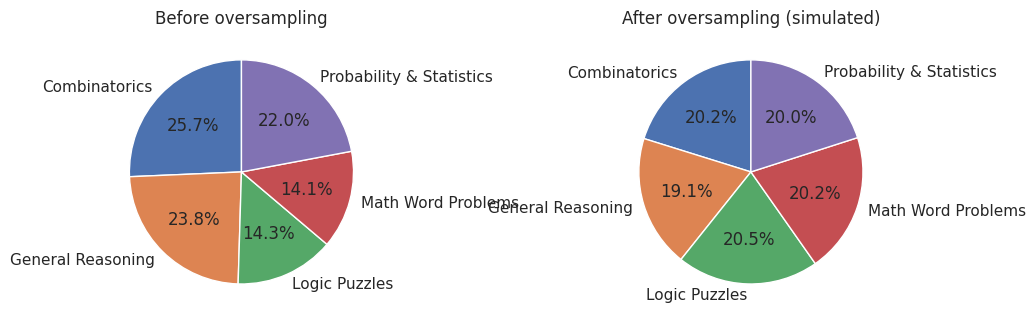

In [39]:
# Oversampling pies only — BEFORE vs AFTER (uses the same y as your sampler)
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import WeightedRandomSampler

# pick the right training labels (after val split if present)
y_base = np.asarray(y_train_sub) if 'y_train_sub' in globals() else np.asarray(y_train)

# rebuild weights to match y_base
class_counts = np.bincount(y_base, minlength=len(CLASSES))
class_weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = class_weights[y_base]

# BEFORE proportions
before_counts = np.bincount(y_base, minlength=len(CLASSES))
before = before_counts / before_counts.sum()

# AFTER proportions (simulate one epoch of WeightedRandomSampler)
weights_t = torch.tensor(sample_weights, dtype=torch.float32)
num_samples = len(sample_weights)
sampler = WeightedRandomSampler(weights=weights_t, num_samples=num_samples, replacement=True,
                                generator=torch.Generator().manual_seed(123))
idx = np.fromiter(iter(sampler), dtype=np.int64, count=num_samples)
after_counts = np.bincount(y_base[idx], minlength=len(CLASSES))
after = after_counts / after_counts.sum()

# pies
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].pie(before, labels=CLASSES, autopct="%1.1f%%", startangle=90)
axes[0].set_title("Before oversampling")

axes[1].pie(after, labels=CLASSES, autopct="%1.1f%%", startangle=90)
axes[1].set_title("After oversampling (simulated)")

plt.tight_layout(); plt.show()


# **Hybrid model (DistilBERT + rules)**

In [40]:

import torch.nn as nn
from transformers import AutoModel

num_labels = len(CLASSES)
rule_dim = len(CLASSES)

class HybridDistilBERT(nn.Module):
    def __init__(self, base="distilbert-base-uncased", rule_dim=rule_dim, num_labels=num_labels, dropout=0.2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(base)
        hidden = self.bert.config.dim  # 768
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden + rule_dim, num_labels)

    def forward(self, input_ids, attention_mask, rules):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:,0,:]
        x = torch.cat([cls, rules], dim=1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

device = "cuda" if torch.cuda.is_available() else "cpu"
model = HybridDistilBERT().to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# **Training loop**

In [41]:

import torch
from torch.optim import AdamW
from torch.nn.functional import cross_entropy
from torch.cuda.amp import autocast, GradScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = AdamW(model.parameters(), lr=3e-5)
scaler = GradScaler(enabled=torch.cuda.is_available())

EPOCHS = 5
PATIENCE = 2
ACCUM_STEPS = 2

best_val_loss = float("inf")
pat = 0
best_state = None

def run_epoch(dl, train=True):
    model.train(train)
    tot, correct, loss_sum = 0, 0, 0.0
    optimizer.zero_grad(set_to_none=True)
    for step, (ids, attn, rules, labels) in enumerate(dl, start=1):
        ids, attn, rules, labels = ids.to(device, non_blocking=True), attn.to(device, non_blocking=True), \
                                   rules.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        with autocast(enabled=torch.cuda.is_available()):
            logits = model(ids, attn, rules)
            loss = cross_entropy(logits, labels)

        if train:
            scaler.scale(loss/ACCUM_STEPS).backward()
            if step % ACCUM_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

        preds = logits.argmax(1)
        tot += labels.size(0)
        correct += (preds == labels).sum().item()
        loss_sum += loss.item() * labels.size(0)


        del logits, loss, preds
        if torch.cuda.is_available() and step % 50 == 0:
            torch.cuda.empty_cache()


    if train and (step % ACCUM_STEPS != 0):
        scaler.step(optimizer); scaler.update(); optimizer.zero_grad(set_to_none=True)

    return loss_sum/tot, correct/tot

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, True)


    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    with torch.no_grad():
        va_loss, va_acc = run_epoch(val_loader, False)

    print(f"Epoch {epoch}: train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")

    if va_loss < best_val_loss - 1e-4:
        best_val_loss = va_loss
        pat = 0
        best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
    else:
        pat += 1
        if pat >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (no val improvement for {PATIENCE} epochs).")
            break

if best_state is not None:
    model.load_state_dict(best_state); model.to(device)


/tmp/ipython-input-3192442350.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-3192442350.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 1: train 0.7440/0.707 | val 0.4875/0.811
Epoch 2: train 0.3001/0.896 | val 0.3404/0.877
Epoch 3: train 0.1780/0.939 | val 0.3314/0.889
Epoch 4: train 0.1143/0.964 | val 0.3257/0.899
Epoch 5: train 0.0766/0.977 | val 0.3349/0.899


# **Final evaluation**

                          precision    recall  f1-score   support

           Combinatorics      0.876     0.929     0.902      1280
       General Reasoning      0.955     0.961     0.958      1189
           Logic Puzzles      0.894     0.944     0.918       713
      Math Word Problems      0.861     0.970     0.913       705
Probability & Statistics      0.913     0.735     0.815      1099

                accuracy                          0.902      4986
               macro avg      0.900     0.908     0.901      4986
            weighted avg      0.904     0.902     0.900      4986



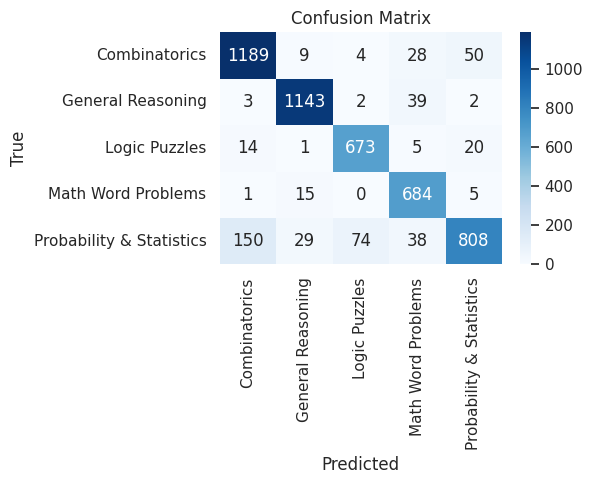

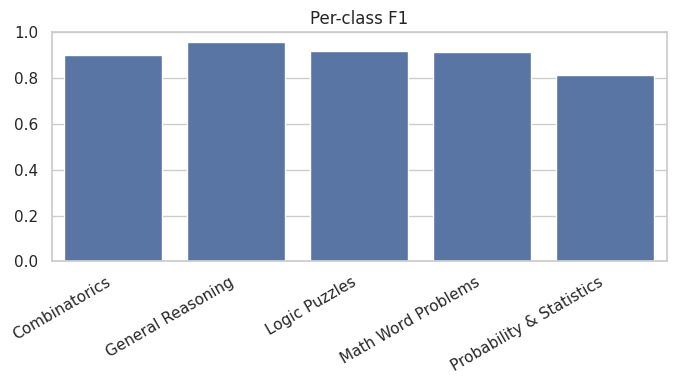

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
import numpy as np, torch

model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for ids, attn, rules, labels in test_loader:
        ids, attn, rules = ids.to(device), attn.to(device), rules.to(device)
        logits = model(ids, attn, rules)
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_true.extend(labels.numpy())

print(classification_report(all_true, all_preds, target_names=CLASSES, digits=3))

cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

# Per-class F1 bar
from sklearn.metrics import precision_recall_fscore_support
_, _, f1, _ = precision_recall_fscore_support(all_true, all_preds, labels=range(len(CLASSES)))
plt.figure(figsize=(7,4))
sns.barplot(x=CLASSES, y=f1)
plt.ylim(0,1); plt.title("Per-class F1"); plt.xticks(rotation=30, ha='right')
plt.tight_layout(); plt.show()


# Macro/Micro F1 from your hybrid model outputs

In [43]:

from sklearn.metrics import f1_score

print("Accuracy:", sum(int(p==t) for p,t in zip(all_preds, all_true)) / len(all_true))
print("Macro F1:", f1_score(all_true, all_preds, average='macro'))
print("Micro F1:", f1_score(all_true, all_preds, average='micro'))
print("Weighted F1:", f1_score(all_true, all_preds, average='weighted'))


Accuracy: 0.9019253910950662
Macro F1: 0.901028065172184
Micro F1: 0.9019253910950662
Weighted F1: 0.8998452235225181


# **Analysis Tool for model performance**

In [44]:

import torch, numpy as np

def predict_category(instruction: str, input_text: str=""):
    text = instruction if not str(input_text).strip() else f"{instruction} [SEP] {input_text}"
    # rule features
    rf = rules_multi_hot(text, CLASSES)
    # tokens
    enc = tokenizer([text], truncation=True, padding=True, max_length=320, return_tensors='pt')
    ids = enc['input_ids'].to(device)
    attn = enc['attention_mask'].to(device)
    rules = torch.tensor(rf, dtype=torch.float32).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(ids, attn, rules)
        pred = int(logits.argmax(1).cpu().item())
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    return CLASSES[pred], {c: float(p) for c,p in zip(CLASSES, probs)}

# quick test
print(predict_category("A fair die is rolled 5 times. Probability of exactly two 6s?"))


('Probability & Statistics', {'Combinatorics': 0.0016342652961611748, 'General Reasoning': 0.00925908237695694, 'Logic Puzzles': 0.00033632127451710403, 'Math Word Problems': 0.0024418048560619354, 'Probability & Statistics': 0.9863285422325134})


In [ ]:
predict_category("A bag contains 3 red and 2 blue marbles. You draw one at random. What’s the chance it’s blue")

('Probability & Statistics',
 {'Combinatorics': 0.0016971065197139978,
  'General Reasoning': 0.0028655901551246643,
  'Logic Puzzles': 0.0001380758621962741,
  'Math Word Problems': 0.0005710856057703495,
  'Probability & Statistics': 0.994728147983551})

predicting probabilty questions

In [ ]:
predict_category("You draw one card from a standard 52-card deck. What are the chances it’s a spade?")
predict_category("Two fair coins are flipped. What are the chances of getting two heads?")
predict_category("You roll a six-sided die once. How likely are you to roll a number greater than 4?")
predict_category("A bag contains 4 red and 6 blue marbles. You pick one without looking. What’s the chance it’s red?")
predict_category("You roll two dice. How many of the 36 outcomes give a sum of 7, and what fraction is that?")
predict_category("From a group of 8 people, 3 are chosen at random. What are the odds that a specific person is selected?")
predict_category("You draw two cards from a shuffled deck, one after the other without replacement. What are the chances both are aces?")
predict_category("A box has 10 bulbs, 2 are defective. You pick one at random. What is the chance it works?")
predict_category("You flip a fair coin three times. In how many of the 8 possible sequences do you get exactly one tail?")
predict_category("From a hat with slips numbered 1 to 10, you draw one slip. How likely is it you draw an even number?")
predict_category("You pick 3 marbles from a bag of 5 green and 5 yellow without replacement. What are the odds all three are green?")
predict_category("A die is rolled twice. What’s the chance of rolling a 2 on the first and a 5 on the second?")
predict_category("In a raffle with 100 tickets, you hold 4 tickets. What are the chances you win at least once?")
predict_category("A drawer has 7 black socks and 9 white socks. You grab two. What is the chance they’re a matching pair?")
predict_category("You roll a fair die four times. What fraction of outcomes gives exactly one six?")
predict_category("You draw one card, then another, with replacement. What are the odds both cards are hearts?")
predict_category("From 12 questions on a quiz, you guess answers randomly. What is the chance of getting exactly 3 correct if each has 4 choices?")
predict_category("A machine fills bottles; 95% fill correctly. You test 5 bottles. What is the chance all five are correctly filled?")
predict_category("You select two people at random from a line of 20. What are the odds you pick two siblings who are standing consecutively?")
predict_category("A spinner is divided into 5 equal sections. What is the chance it lands on the blue section in one spin?")


('Probability & Statistics',
 {'Combinatorics': 0.016777900978922844,
  'General Reasoning': 0.3987826406955719,
  'Logic Puzzles': 0.0009795122314244509,
  'Math Word Problems': 0.006089434027671814,
  'Probability & Statistics': 0.5773705244064331})

predicting general reasoning question

In [45]:
predict_category("There are two doors: one to freedom and one to a trap, with two guards (one always tells the truth, the other always lies). You may ask one yes/no question to one guard. What do you ask?")
predict_category("You have three boxes labeled 'Apples', 'Oranges', and 'Apples & Oranges', but all labels are wrong. By drawing a single fruit from one box, how can you correctly label all three?")
predict_category("A mother is twice as old as her child. In five years, she will be three times as old. How old are they now?")
predict_category("On an island of knights (always truthful) and knaves (always lying), A says 'B is a knight.' B says 'A and I are different types.' What are A and B?")
predict_category("Three neighbors—Lee, Sam, and Pat—own exactly one pet each: a cat, a bird, or a rabbit. Lee does not own the rabbit. Sam says 'I don't own the bird.' Pat says 'Sam owns the cat.' Who owns which pet?")
predict_category("You stand outside a room with three switches and inside there’s one light bulb. Exactly one switch controls it. You can flip switches any way you like, then enter the room only once. How do you figure out which switch operates the bulb?")
predict_category("A farmer must ferry a wolf, a goat, and a cabbage across a river in a boat that holds the farmer plus one item. If left alone, the wolf eats the goat and the goat eats the cabbage. How can he get all across safely?")
predict_category("There are three people in a room; each is either a truth-teller (always truthful) or a liar (always lies). One says 'Exactly one of us is a truth-teller.' How many truth-tellers are there?")
predict_category("Three houses—red, green, and blue—stand in a row. The Englishman lives in the red house. The Swede has a dog. The Dane drinks tea. The green house is immediately to the left of the white house. Who drinks coffee?")
predict_category("Four suspects (A, B, C, D) are questioned about a theft. A says 'I didn't do it.' B says 'C did it.' C says 'B is lying.' Only one person tells the truth. Who stole it?")
predict_category("Four people must cross a bridge at night with one flashlight. They take 1, 2, 7, and 10 minutes to cross. At most two can cross at once. How can they all cross in 17 minutes?")
predict_category("You have 12 coins; one is counterfeit (heavier or lighter). Using a balance scale only three times, how can you identify the counterfeit coin and whether it’s heavier or lighter?")
predict_category("A man walks south three miles, west three miles, then north three miles and ends up where he started. What color is the bear he sees?")
predict_category("A father is three times as old as his son. In 12 years, the father will be twice as old as the son. How old are they now?")
predict_category("Three people each wear a hat that is either white or black. Each can see the other hats but not their own. A says 'I don't know my hat color.' B says 'I don't know mine.' C says 'Now I know mine.' What color is C's hat?")
predict_category("On an island, a person says 'I am a knave.' Is that possible, and if so, what is he?")
predict_category("Alice, Bob, Carol, and Dave each chose a different fruit: apple, banana, cherry, or date. Bob chose apple. Carol didn’t choose banana. Dave’s fruit starts with 'D'. Who chose cherry?")
predict_category("A says 'We are both knaves.' B says 'A is a knight.' On an island of knights and knaves, who are A and B?")
predict_category("The day before two days after the day before tomorrow is Friday. What day is today?")
predict_category("What English word is always spelled incorrectly?")

('General Reasoning',
 {'Combinatorics': 0.00048406244604848325,
  'General Reasoning': 0.9975989460945129,
  'Logic Puzzles': 0.0003184222150593996,
  'Math Word Problems': 0.0008329072152264416,
  'Probability & Statistics': 0.0007656821981072426})

predicting logic puzzle questions

In [46]:
predict_category("On a 4x4 grid, shade cells so each row and column has exactly two shaded cells and no two shaded cells touch orthogonally. Is a solution possible?")

predict_category("Three islanders (A, B, C) are knights or knaves. A: 'B and I are the same type.' B: 'C is a knave.' C: 'Exactly one of us is a knight.' Determine each type.")

predict_category("Place 5 queens on a 5x5 chessboard so no two attack each other. A queen is fixed at (2,4). Give one full placement or say impossible.")

predict_category("Can an 8x8 board with opposite corner squares removed be perfectly tiled by 2x1 dominoes? Justify yes or no.")

predict_category("In a 3x3 Lights Out board, the lights on are the center and the four corners. What is the minimum number of presses to turn all lights off?")

predict_category("Complete a 4x4 Sudoku with digits 1–4 (Latin constraints and 2x2 subgrids). Clues: R1: _ 2 _ _; R2: _ _ 3 _; R3: _ 4 _ _; R4: _ _ _ 1.")

predict_category("A simple graph has vertices {A,B,C,D,E} and edges {AB, AC, AD, BE, CE, DE}. Does it have an Eulerian trail? Does it have a Hamiltonian cycle?")

predict_category("On a 5x5 grid, draw a single non-self-intersecting path from (1,1) to (5,5) moving only right or down. Cells (2,2), (3,3), and (4,2) are blocked. Is a path possible?")

predict_category("Tile a 6x6 board using L-trominoes after removing squares (1,1) and (6,6). Can the remaining 34 squares be tiled without overlap?")

predict_category("Does a closed knight's tour exist on a 5x5 chessboard starting at (1,1)? If yes, explain; if not, state why.")


('Logic Puzzles',
 {'Combinatorics': 0.00031542161013931036,
  'General Reasoning': 0.001017836737446487,
  'Logic Puzzles': 0.9970359802246094,
  'Math Word Problems': 0.00042970303911715746,
  'Probability & Statistics': 0.0012010690988972783})

predicting math word problems

In [47]:
predict_category("Two trains start 300 km apart and travel toward each other at 80 km/h and 70 km/h. At what time do they meet, and how far from the first station?")

predict_category("A chemist needs 200 mL of a 30% salt solution. She has 20% and 50% solutions. How many milliliters of each should she mix?")

predict_category("A rectangle has perimeter 64 cm. If its length is twice its width, find the area in square centimeters.")

predict_category("A and B together can complete a job in 6 hours. A alone takes 10 hours. How long does B alone take to finish the work?")

predict_category("A store marks a jacket at $120 and offers a 25% discount, then adds 8% sales tax. What is the final price?")

predict_category("Simple interest: $5,000 is invested at 6% per year. How much interest is earned in 18 months, and what is the total amount?")

predict_category("An isosceles triangle has equal sides 10 cm and base 12 cm. Find its area and the height to the base.")

predict_category("A car travels at 60 km/h for 2.5 hours, then at 48 km/h for 1.5 hours. What is the total distance and average speed for the trip?")

predict_category("A 1,000-liter tank contains water with 5% dye. How many liters must be drained and replaced with pure water to reduce the concentration to 2%?")

predict_category("The length of a rectangle is (x+3) m and the width is (x−1) m. If the area is 140 m^2, form and solve the quadratic equation for x.")

('Math Word Problems',
 {'Combinatorics': 0.0002782367228064686,
  'General Reasoning': 4.5362114178715274e-05,
  'Logic Puzzles': 0.00016181572573259473,
  'Math Word Problems': 0.9988136291503906,
  'Probability & Statistics': 0.0007009285618551075})

In [48]:
predict_category("Max tested a coin to see whether it was fair. The table shows the results of his coin toss experiment:")

('Probability & Statistics',
 {'Combinatorics': 0.0012117992155253887,
  'General Reasoning': 0.0010749500943347812,
  'Logic Puzzles': 0.0009797331877052784,
  'Math Word Problems': 0.0011064168065786362,
  'Probability & Statistics': 0.9956270456314087})

In [49]:
predict_category("One side of a rectangle is 3 cm shorter than the other side. If we increase the length of each side by 1 cm, then the area of the rectangle will increase by 18 cm2. Find the lengths of all sides.")

('Math Word Problems',
 {'Combinatorics': 0.002749119885265827,
  'General Reasoning': 7.867685781093314e-05,
  'Logic Puzzles': 0.0002351012808503583,
  'Math Word Problems': 0.9961625337600708,
  'Probability & Statistics': 0.0007744818576611578})

In [50]:
predict_category("What is the mean of 44, 22, 134, and 200?")

('Probability & Statistics',
 {'Combinatorics': 0.00013498717453330755,
  'General Reasoning': 0.0003275291819591075,
  'Logic Puzzles': 7.963553071022034e-05,
  'Math Word Problems': 0.00012153104762546718,
  'Probability & Statistics': 0.9993364214897156})

In [51]:
predict_category("You are outside a closed room with three light switches. Only one of them controls a light inside the room. You can flip the switches as much as you want, but you can only enter the room once to check. How do you know which switch controls the light?")

('Logic Puzzles',
 {'Combinatorics': 5.437418803921901e-05,
  'General Reasoning': 0.0003222856030333787,
  'Logic Puzzles': 0.9896219968795776,
  'Math Word Problems': 0.0001799989549908787,
  'Probability & Statistics': 0.009821350686252117})